# ランダム変数と景気循環

## 始める前に

次のセルの１行目以外をアンコメント（`# `を削除）しなさい。アンコメントするには次の手順に従う。
* Windowsの場合：１行目以外の全ての行を選択し，`Ctrl`を押したまま`/`を押す。
* Macの場合：１行目以外の全ての行を選択し，`command`を押したまま`/`を押す。

In [1]:
# CELL PROVIDED
# import piplite
# await piplite.install(['py4macro','japanize-matplotlib-jlite'])
# %matplotlib inline
# import statsmodels
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (4, 3)

次のコードを実行しなさい。

In [39]:
# CELL PROVIDED
import japanize_matplotlib_jlite
import numpy as np
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

np.set_printoptions(legacy='1.21')

## ランダム変数の役割

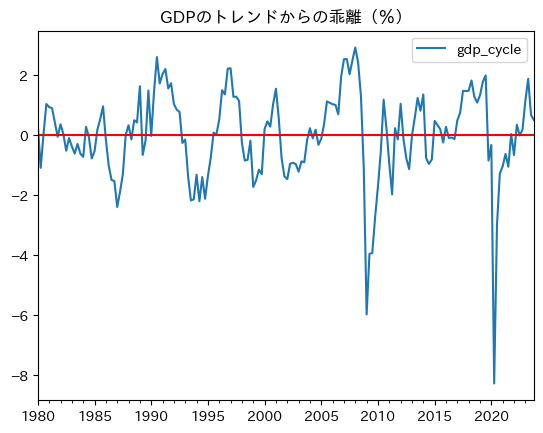

In [3]:
# CELL PROVIDED

# データの読み込み
df = py4macro.data('jpn-q')

# トレンドからの％乖離のデータの作成
df['gdp_cycle'] = 100 * (
    np.log( df['gdp'] ) - py4macro.trend( np.log(df['gdp']) )
)

# プロット
ax = df.plot(y='gdp_cycle', title='GDPのトレンドからの乖離（％）')
ax.axhline(0, c='red')
pass

このようなGDPの変動を説明する方法として２つある。
1. 決定的（deterministic）な過程で生成された時系列として捉える。
    * 差分方程式$x_{t+1}=f(x_t)$のように来期のGDPは今期のGDPに依存している。マクロ変数の持続性を捉えるには必要不可欠な特徴と言えるだろう。しかし，今期のGDP（$x_t$）が与えられると来期のGDP（$x_{t+1}$）は自ずと決定さることになり，来期のGDPの予測は簡単なものとなる。もしそうであれば政策運営は非常に簡単であろうが，現実はそうではない。そういう意味では，現実を十分に捉えることができていない。
1. ランダム（stochastic）な過程で生成された時系列として捉える。
    * ランダム変数の実現値の連続としてGDPが観測され，今期のGDPが与えられても来期のGDPにはランダムな要素があるため，予測が難しいという特徴がある。この特徴こそが，マクロ変数の性質を捉えるには必要な要素であり，上のプロットに現れていると考えられる。

以下では，まずランダム変数生成過程を考え，短期分析における全要素生産性の役割について説明する。またSolowモデルを使い簡単な景気循環モデルを展開する。

## ホワイト・ノイズ

### 説明

時系列のランダム変数$\varepsilon_t$，$t=0,1,2,3,\cdots$を考えよう。例えば，レストランの経営者の収入。ビジネスにはリスク（競争相手の出現やコロナ感染症問題）があるため変動すると考えるのが自然である。$\varepsilon_t$は$t$毎にある分布から抽出されると考えることができる。次の３つの性質を満たしたランダム変数をホワイト・ノイズ（White Noise）と呼ぶ。
1. 平均は`0`：$\quad\text{E}\left[\varepsilon_t\right]=0$
1. 分散は一定：$\text{ E}\left[\varepsilon_t^2\right]=\sigma^2$（$\sigma^2$に$t$の添字はない）
1. 自己共分散は`0`：$\text{ E}\left[\varepsilon_t \varepsilon_{t-s}\right]=\sigma_{\varepsilon_t \varepsilon_{t-s}}^2=0$（全ての$s\ne 0$に対して）。従って，自己相関係数も`0`となる。）

    $$
    \text{自己相関係数}=\frac{\sigma_{\varepsilon_t \varepsilon_{t-s}}^2}
                           {\sigma_{\varepsilon_t}\times\sigma_{\varepsilon_{t-s}}}
                           =0
    $$

* 平均0と分散が$\sigma^2$のホワイト・ノイズを次のように表記する。

    $$
    \varepsilon_t\sim\textit{WN}(0,\sigma^2)
    $$
    
* ホワイト・ノイズの例：
    * 平均`0`，分散$\sigma^2=2$の正規分布から抽出された$\varepsilon_t$
    * 最小値`10`，最大値`100`の一様分布からから抽出された$\varepsilon_t$
    * （正規分布や一様分布ではない分布でもホワイト・ノイズになり得る）
* ホワイト・ノイズは独立同分布（Indepent and Identically Distributed）の１つである。

以下では実際にランダム変数を発生させ，そのプロットと統計的な特徴について考察する。その準備として次のコードを実行しよう。

In [4]:
rng = np.random.default_rng()

ランダム変数の「種」になるオブジェクトと作成し、それを`rng`に割り当てている。

(`NumPy`を使いランダム変数を生成する方法については，[「経済学のためのPython入門」のNumpy: ランダム変数](https://py4basics.github.io/8_NumPy_random.html)を参考にしてください。)

### 正規分布

`rng.normal(loc=0, scale=1, size=1)`
```
    loc：平均（デフォルトは0）

    scale：標準偏差（デフォルトは`1`; 分散ではない！）

    size：ランダム変数の数（デフォルトは1）
```
ここで、`.normal()`は`rng`のメソッドである。例として、平均`5`，標準偏差`2`の標準正規分布から`10`のランダム変数を生成しよう。

In [5]:
rng.normal(5, 2, 10)

array([3.43475433, 5.29029348, 5.08608211, 6.82133593, 2.67751492,
       8.91235214, 6.24085878, 6.52284426, 2.35020585, 5.78416645])

### 連続一様分布分布

`rng.uniform(low=0, high=1.0, size=1)`
```
    low：最小値（デフォルトは0）

    hight：最大値（デフォルトは`1`; 分散ではない！）

    size：ランダム変数の数（デフォルトは1）
```
ここで、`.uniform()`は`rng`のメソッドである。例として、最小値`1`，最大値`10`のとして`10`のランダム変数を生成しよう。

In [6]:
rng.uniform(1, 10, size=10)

array([2.28876159, 3.6359413 , 7.31919339, 4.09975288, 1.54775088,
       5.42335388, 4.16144594, 4.36359368, 3.8860589 , 4.74430388])

### 図示

標準正規分布からのランダム変数を`n`個抽出しプロットしてみよう。

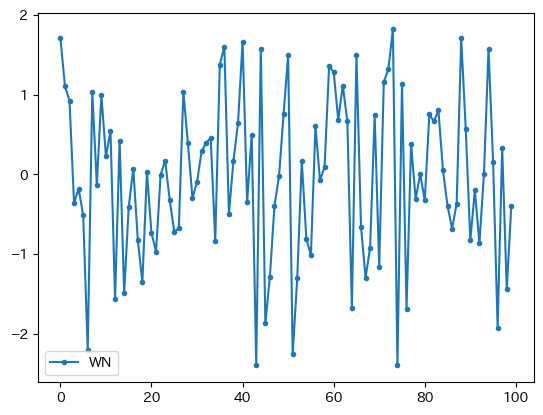

In [7]:
n = 100

vals = rng.normal(loc=0, scale=1, size=n)

dfwn = pd.DataFrame({'WN':vals})

dfwn.plot(marker='.')
pass

２つの特徴がある。
* 平均`0`：`0`を中心に周辺を動いている。
* 分散一定：`0`から外れても`0`に戻っている。

平均と分散を計算してみよう。

In [8]:
vals.mean(), vals.var()

(np.float64(-0.03352271377669365), np.float64(1.063102520938104))

サンプル統計量であるため誤差が発生していることがわかる。

２つの特徴をを確認するために`Pandas`の`plot()`を使ってヒストグラムを描いてみる。

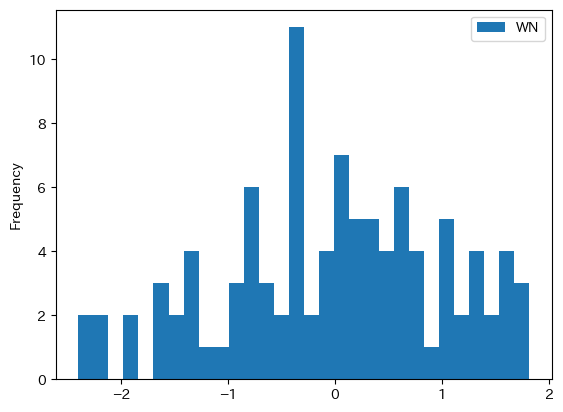

In [9]:
dfwn.plot(kind='hist', bins=30)
pass

概ね`0`を中心に左右対象に動いている。即ち，平均`0`を反映している。また，`0`から離れている観測値が少ないことが分かる。これは`0`方向に戻ることを示しており，分散が一定となるためである。この性質は`n`を`500`や`1000`などの大きな数字に設定するより一層分かりやすいだろう。

### 自己共分散（自己相関）

次に１期違いの自己共分散$\text{E}[\varepsilon_t \varepsilon_{t-1}]$を考えるために，`df_wn`の列`WN`を`1`期シフトさせた新たな列`WNlag`を作成しよう。

In [10]:
dfwn['WNlag'] = dfwn['WN'].shift()
dfwn.head()

,WN,WNlag
0,1.710196,NaN
1,1.106741,1.710196
2,0.919282,1.106741
3,-0.361727,0.919282
4,-0.178844,-0.361727


`WNlag`の値は`WN`の値が`1`期シフトしていることが分かる。行インデックスを期間と考えてみよう。`0`番目の行は初期であり、
更に、`1`番目の行の`WN`には`1`期目の値があり、`WNlag`には`0`初期の値が入っている。
同様に、`2`番目の行の`WN`には`2`期目の値があり、`WNlag`には`1`期目の値が入っている。
即ち、各行には今期と前期の値が並んでいる。

この２つの列を使って散布図を描いてみる。`Pandas`の`plot()`で横軸・縦軸を指定し，引数`kind`で散布図を指定するだけである。

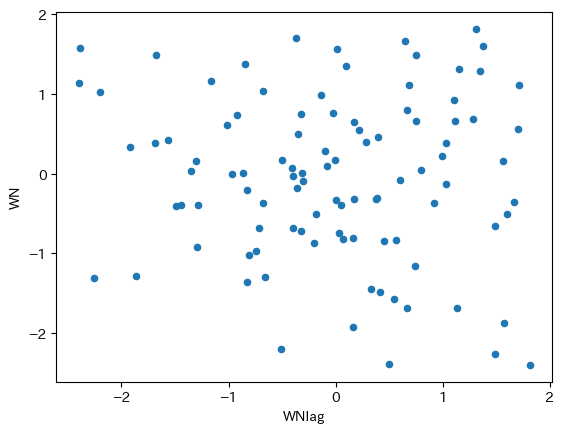

In [11]:
dfwn.plot(x='WNlag', y='WN', kind='scatter')
pass

自己共分散がゼロであれば，ランダムに散らばっているはずであり，何らかのパターンも確認できないはずである。

分散・自己共分散を計算してみよう。

In [12]:
dfwn.cov()

,WN,WNlag
WN,1.073841,-0.083326
WNlag,-0.083326,1.083442


左上と右下の対角線上にあるのは、`WN`と`WNlag`の不偏分散であり、`1`に近い値となっている。一方、右上と左下の値（同じ値となる）が**自己共分散**であり、非常に小さな値である。自己共分散は`0`という仮定を反映している。（`WN`と`WNlag`の不偏分散は異なるが、その理由は？）

次にメソッド`autocorr()`を使い**自己相関係数**を計算しよう。

In [13]:
dfwn['WN'].autocorr()

np.float64(-0.07799500874546574)

自己共分散`0`の仮定を反映した結果であり，ホワイト・ノイズには持続性がない。この結果からわかることは，ホワイト・ノイズだけではマクロ変数の持続性を説明できないということである。

## 自己回帰モデル：AR(1)

### 説明

次に確率過程として自己回帰モデルを考えよう。英語で**A**ugo**r**egressive Modelと呼ばれ，AR(1)と表記されるモデルは次式で表される。（AR(1)の`(1)`は右辺と左辺の変数は１期しか違わないことを表している。）

$$
y_t=\rho y_{t-1}+\varepsilon_t
$$

ここで
* $y_t$：$t$期の$y$の値
* $-1<\rho<1$
* $\varepsilon_t\sim WN(0,\sigma^2)$（ホワイト・ノイズ）

$\varepsilon_t$を所与とすると$y_t$の差分方程式となっている。$-1<\rho<1$となっているため，安定的な過程であることがわかる。即ち，$\varepsilon_t=0$であれば、$y_t=$は定常状態である$0$に近づいて行くことになる。しかしホワイト・ノイズである$\varepsilon_t$により、毎期確率的なショックが発生し$y_t$を定常状態から乖離させることになる。また式[](eq:13-ar1)からわかるように，今期の値$y_t$は前期の値$y_{t-1}$に依存しており，その依存度はパラメータ$\rho$によって決定される。この$\rho$こそが$y_t$の持続性の強さを決定することになり，自己回帰モデル[](eq:13-ar1)の自己相関係数は$\rho$と等しくなる。

### ３つの例：持続性の違い

$\rho$の値を変えて持続性の違いを視覚的に確認するための関数を作成しよう。

"""
引数：
    rho: AR(1)の持続性を捉えるパラメータ
    y0:  初期値
    s: 撹乱項の標準偏差
    T:   シミュレーションの回数
戻り値：
    AR(1)のSeries
"""

In [156]:
def ar1_data(rho, y0, s, T):
    """引数：
            rho: AR(1)の持続性を捉えるパラメータ
            y0:  初期値
            s: 撹乱項の標準偏差
            T:   シミュレーションの回数
       戻り値：
            AR(1)のSeries"""
    
    y = y0
    y_lst = [y]
    e_lst = [0]

    for t in range(1,T):
        e = rng.normal(scale=s)   # 平均0
        y = rho*y + e
        y_lst.append(y)
        e_lst.append(e)

    return pd.DataFrame({'yt':y_lst, 'et':e_lst})

"""引数：
        rho: AR(1)の持続性を捉えるパラメータ
        y0:  初期値（デフォルト：0）
        s: 撹乱項の標準偏差
        T:   シミュレーションの回数（デフォルト：100）
   戻り値：
        matplotlibの図を示す
        自己相関係数の値を表示する
"""

In [159]:
def ar1_plot(rho, y0=0, s=1, T=100):
    """引数：
            rho: AR(1)の持続性を捉えるパラメータ
            y0:  初期値（デフォルト：0）
            T:   シミュレーションの回数（デフォルト：100）
       戻り値：
            matplotlibの図を示す
            自己相関係数の値を表示する"""
    
    df_ar1 = ar1_data(rho=rho, y0=y0, s=1, T=T)['yt']
    
    ac = df_ar1.autocorr()
    
    ax_ = df_ar1.plot(marker='.')
    ax_.set_title(fr'$\rho$={rho}　　自己相関係数：{ac:.3f}',size=20)
    ax_.axhline(0, c='red')

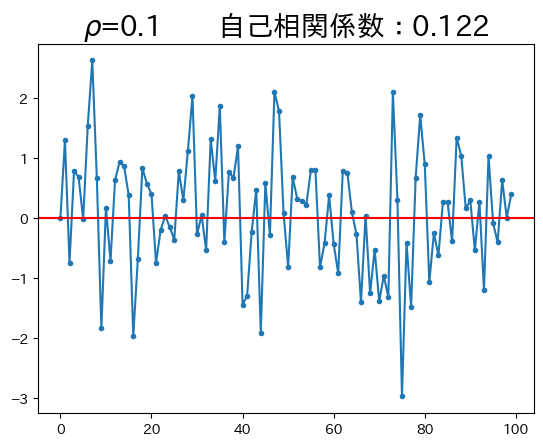

In [158]:
ar1_plot(0.1)

この例では$\rho$の値が低いため，$y$は定常状態の0に直ぐに戻ろうとする力が強い。従って、前期の値の今期の値に対する影響力が小さいため、持続性が低い。

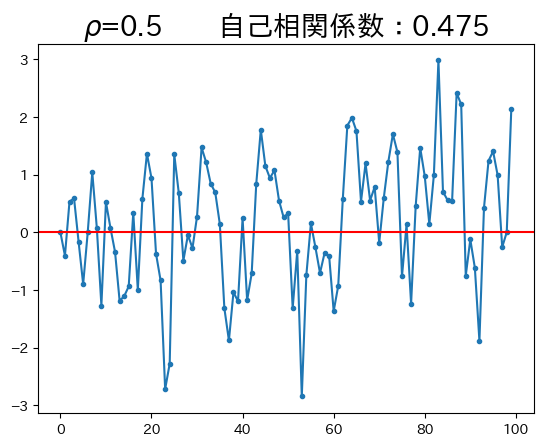

In [160]:
ar1_plot(0.5)

$\rho$の値が高くなると、定常状態の$0$に戻ろうとする作用が弱くなり、持続性が強くなることがわかる。

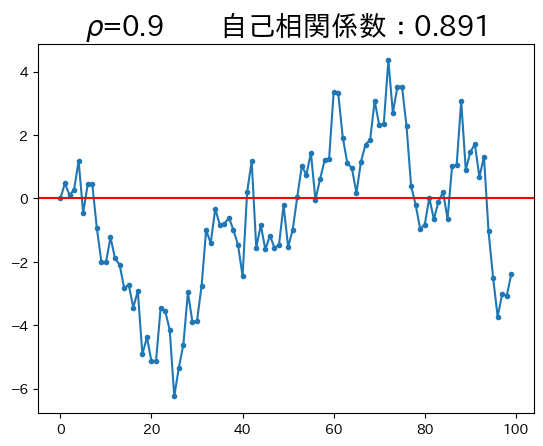

In [161]:
ar1_plot(0.9)

$\rho$が非常に高いため、持続性も非常に強くなっている。即ち、今期の値は前期の値に対する依存度が大きい。

## 定量的な分析

### 定量的な問

上述の`AR(1)`を考えよう。$y_t$が変動する要因は２つある。
1. $y_{t-1}$：前期の値の影響
2. $\varepsilon_t$：確率的な影響
  
> $y_t$が変動する原因の何％が前期の影響で，残りの何％が確率的な影響なのか？

### 分散分解

**＜分散と共分散＞**

ランダム変数$x$と$z$を考えよう。
* $x$の分散：$\text{Var}(x)$（variance）
* $x$と$z$の共分散：$\text{Cov}(x,z)$（covariance）
* $x$と$z$の共分散は$x$の分散と等しい，即ち，$\text{Cov}(x,x)=\text{Var}(x)$

**＜分散分解＞**

`AR(1)`の両辺の分散

\begin{align}
\text{Var}(y_t)
&=\text{Cov}(y_t,y_t)\\
&=\text{Cov}(y_t,\rho y_{t-1} + \varepsilon_t)\\
&=\text{Cov}(y_t,\rho y_{t-1})+\text{Cov}(y_t,\varepsilon_t)\\
&=\rho\text{Cov}(y_t,y_{t-1})+\text{Cov}(y_t,\varepsilon_t)\\
y_t\text{の変動}
&=[y_{t-1}\text{による}y_t\text{の変動}]+[\varepsilon_t\text{による}y_t\text{の変動}]
\end{align}

**＜各要素の貢献度＞**

\begin{align}
&y_{t-1}\text{の貢献度}=\frac{y_{t-1}\text{による}y_t\text{の変動}}{y_t\text{の変動}}
=\rho\frac{\text{Cov}(y_t,y_{t-1})}{\text{Var}(y_t)}\\
&\varepsilon_t\text{の貢献度}=\frac{\varepsilon_t\text{による}y_t\text{の変動}}{y_t\text{の変動}}
=\frac{\text{Cov}(y_t,\varepsilon_t)}{\text{Var}(y_t)}
\end{align}

これらを計算することにより、各要素が$y_t$の変動に何％貢献しているかを数量化できる。

### 各要素の貢献度の計算：シミュレーション

上で作成した`ar1_data()`関数に次の引数を使ってデータを生成しよう。
* `rho`：`0.5`
* `y0`：`0`
* `T`：`1,000,000`

In [163]:
rho = 0.5
ts = ar1_data(rho=rho, y0=1, s=1, T=1_000_000)
ts.head()

,yt,et
0,1.000000,0.000000
1,1.313327,0.813327
2,-1.340444,-1.997108
3,-2.083576,-1.413354
4,-1.328370,-0.286582


`Series`のメソッド`.shift()`を使い，`1`期ずらした列を作成する。

In [164]:
ts['yt-1'] = ts['yt'].shift(-1)
ts.head()

,yt,et,yt-1
0,1.000000,0.000000,1.313327
1,1.313327,0.813327,-1.340444
2,-1.340444,-1.997108,-2.083576
3,-2.083576,-1.413354,-1.328370
4,-1.328370,-0.286582,-0.229379


#### $y_{t-1}$の貢献度

分散行分散を計算する。

In [165]:
varcov = ts.cov()
varcov

,yt,et,yt-1
yt,1.330114,0.998604,0.663020
et,0.998604,0.999623,0.497574
yt-1,0.663020,0.497574,1.330115


In [166]:
# ytの分散
yt_var = varcov.iloc[0,0]

# yt-1の分散
ytpre_var = varcov.iloc[2,2]

# ytとyt-1の共分散
yt_ytpre_cov = varcov.iloc[0,2]

# ytとetの共分散
yt_et_cov = varcov.iloc[0,1]

#### $\varepsilon_{t}$の貢献度

In [167]:
yt_contribution = rho * yt_ytpre_cov / yt_var
yt_contribution

0.2492340944698811

$\varepsilon_t$の貢献度

In [168]:
e_contribution = yt_et_cov / yt_var
e_contribution

0.7507654031978401

確認

In [169]:
yt_contribution + e_contribution

0.9999994976677212

#### 補足

理論的には次のようになる。まず、$t\rightarrow\infty$を考えた場合，

\begin{align}
\text{Cov}(y_t,y_{t-1})
&=\text{Cov}(\rho y_{t-1}+\varepsilon_t,y_{t-1})\\
&=\text{Cov}(\rho y_{t-1},y_{t-1})+\text{Cov}(\varepsilon_t,y_{t-1})\\
&=\rho\text{Cov}(y_{t-1},y_{t-1})+0\\
&=\rho\text{Var}(y_{t-1})\\
&=\rho\text{Var}(y_{t})
\end{align}

が成立する。ここで、最後の行は$t\rightarrow\infty$の下では$y_t$と$y_{t-1}$の分散は同じと考えることができるためである。
即ち，$\text{Var}(y_t)=\text{Var}(y_{t-1})$。従って，

\begin{align}
y_{t-1}\text{の貢献度}
&=\rho\frac{\text{Cov}(y_t,y_{t-1})}{\text{Var}(y_t)}
=\rho\frac{\rho\text{Var}(y_t)}{\text{Var}(y_t)}
=\rho^2
\end{align}

$\rho=0.5$とすると、$y_{t-1}$の貢献度は$\rho^2=0.25$となり、$\varepsilon_{t-1}$の貢献度は0.75となる。上の計算では$T<\infty$であるため、誤差が発生している。